# Faster RCNN

This is a jupyter notebook that is designed to train an object detection for detecting faces and classifying if they are wearing mask or no mask. 

It is built based on [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497) from Microsoft team.

It is also built with google colab, you may need to include some google colab's dependencies in your notebook or simply run them online in google colab environment. It is more advised to run in google colab as some features may not be supported in jupyter notebook.

# Preparation

## Install and import the required dependencies

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 6.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=fd2686e6f8793003226129474a9a8c8a5a79feb23773fd998ac12b353322bf52
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-lntjv3og
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-lntjv3og
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

install detectron2, which is from facebook group

In [2]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 726kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200613-cp36-none-any.whl size=41028 sha256=e52de09efadd51004d532885c49cb6f1432580915e72f9594b2cd3a11642dd1b
  Stored in directory: /root/.cache/pip/wheels/bf/54/92/c61c94b4b7c491dec867d287a75ef6fa0a536ab64920e8b778
Successfully built fvcore


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import os
from shutil import copyfile

Download the datasets

In [4]:
!wget https://cloud.tsinghua.edu.cn/f/4279772e0ea7499faa42/?dl=1 -O face_mask.zip

--2020-06-13 09:02:09--  https://cloud.tsinghua.edu.cn/f/4279772e0ea7499faa42/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.8.7
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.8.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/597711c3-c00e-411c-8aa4-a5952616f635/face_mask.zip [following]
--2020-06-13 09:02:11--  https://cloud.tsinghua.edu.cn/seafhttp/files/597711c3-c00e-411c-8aa4-a5952616f635/face_mask.zip
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 800641476 (764M) [application/zip]
Saving to: ‘face_mask.zip’

face_mask.zip       100%[===================>] 763.55M  9.64MB/s    in 81s     

2020-06-13 09:03:32 (9.43 MB/s) - ‘face_mask.zip’ saved [800641476/800641476]



Unzip the datasets

In [0]:
!unzip face_mask.zip > /dev/null

Remove the zip file to free up spaces

In [0]:
os.remove("face_mask.zip")

# Run a pre-trained detectron2 model

Let's show a random image from the dataset

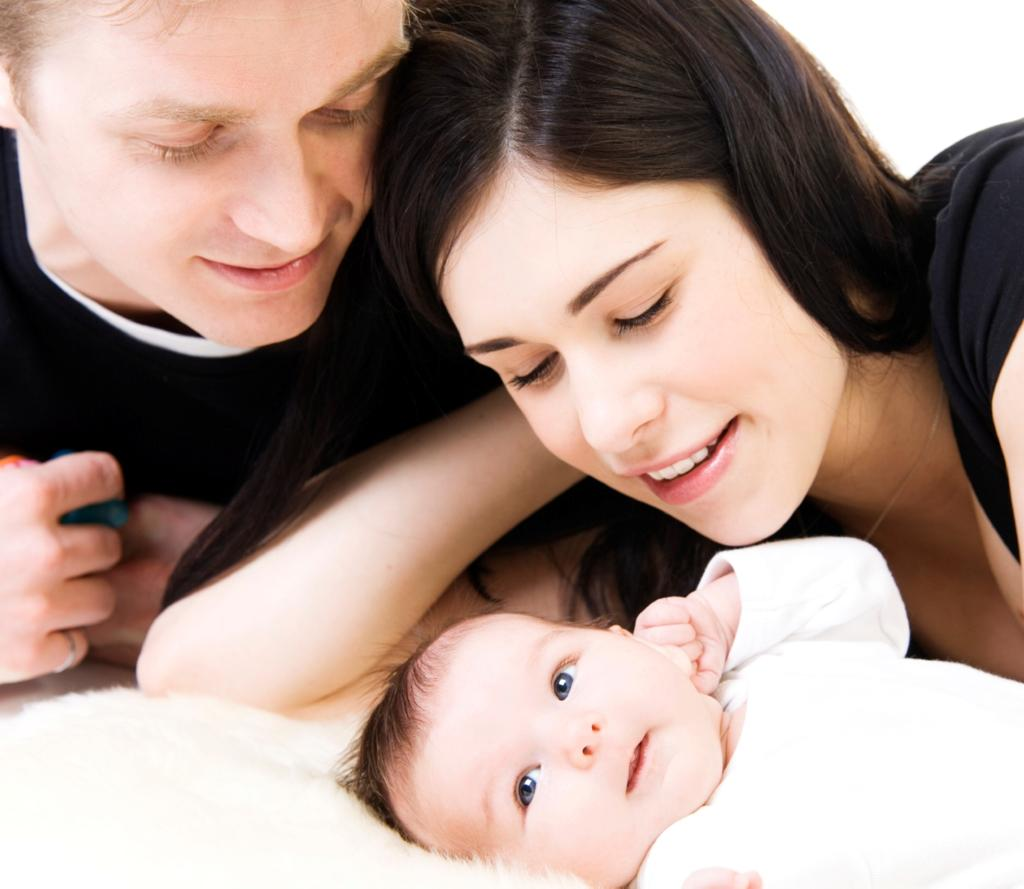

In [7]:
im = cv2.imread("face_mask/train/19_Couple_Couple_19_173.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image. We use a pretrained weight for showing purpose.

In [8]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_280758.pkl: 167MB [00:17, 9.82MB/s]                           


look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification


In [9]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0, 0, 0], device='cuda:0')
Boxes(tensor([[1.5382e+02, 5.6659e+00, 1.0188e+03, 8.6640e+02],
        [8.0627e-01, 4.0482e+00, 4.4949e+02, 6.6155e+02],
        [9.1384e+02, 1.2227e+02, 1.0240e+03, 6.2724e+02]], device='cuda:0'))


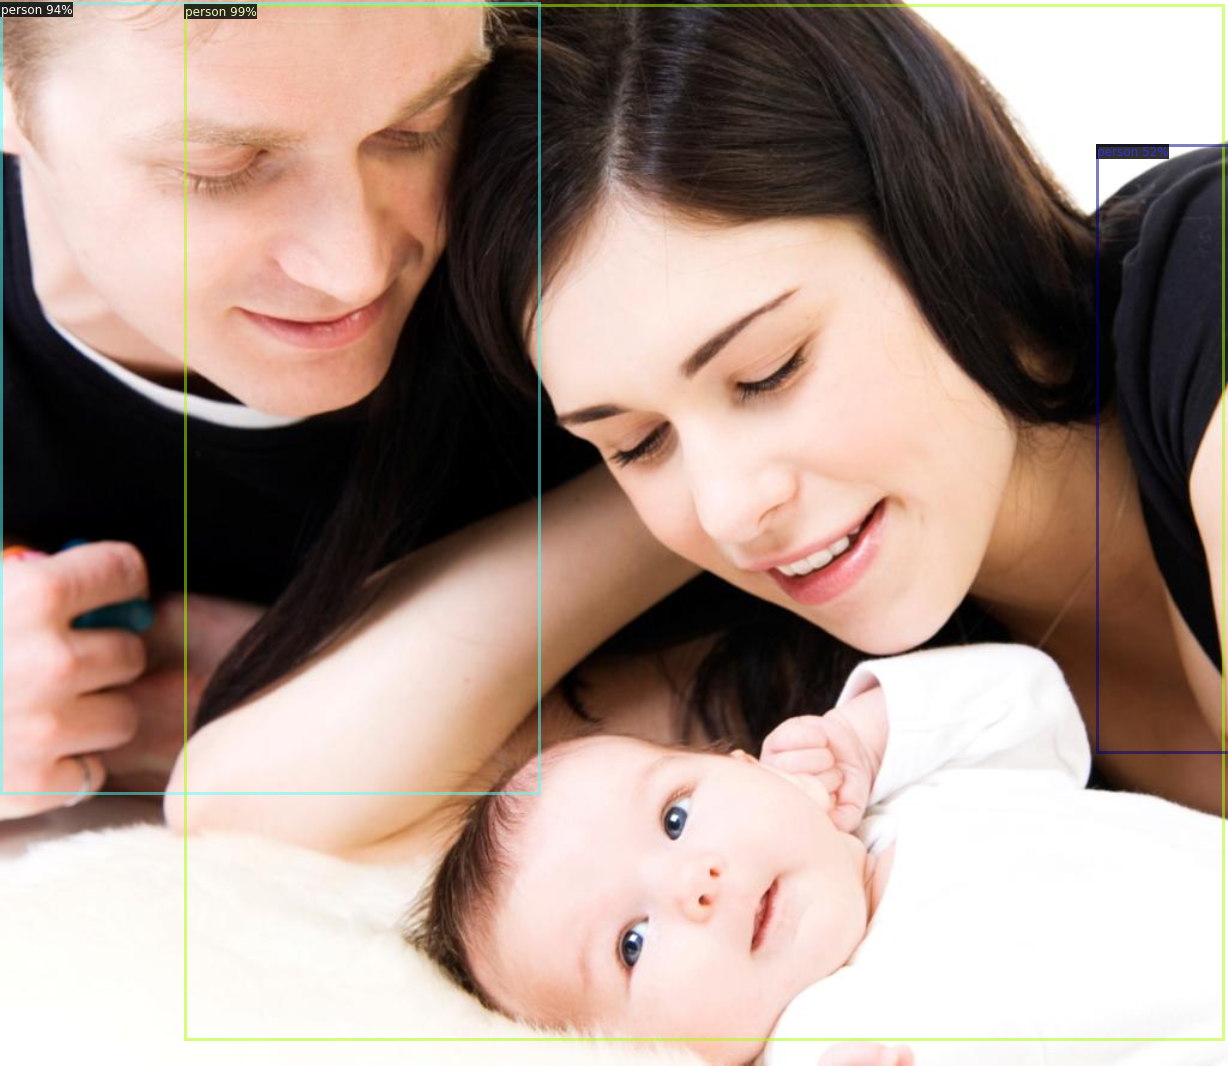

In [10]:
# We can use `Visualizer` to draw the predictions on the image.
# print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use the face_mask dataset from AIZOO(https://github.com/AIZOOTech/FaceMaskDetection).
which has two classes: face_mask and face.
We'll train a face_mask/face object detection model from random weights.

Note that COCO dataset does not have the "face_mask" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

Register the face and face_mask dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. 

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_facemask_dict(img_dir,jsonName):
  json_file = os.path.join("face_mask",img_dir, jsonName)
  with open(json_file) as f:
    imgs_anns = json.load(f)

  dataset_dicts = []
  for idx, v in enumerate(imgs_anns['images']):
    record = {}
    filename = os.path.join("face_mask",img_dir, v['id'])
    height, width = cv2.imread(filename).shape[:2]

    record["file_name"] = filename
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width
    objs = []
    for _, annos in enumerate(imgs_anns['annotations']):
      if annos['image_id'] == v['id']:
        data = annos['bbox']
        obj = {
        "bbox": data,
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": annos['segmentation'],
        "category_id": annos['category_id']-1,
        }
        objs.append(obj)
    record["annotations"] = objs
    dataset_dicts.append(record)
      
  return dataset_dicts

Regitster the datasets to catalog according to if its for training or validation purpose.

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog._REGISTERED.clear()
for d in ["train", "val"]:
  DatasetCatalog.register("face_mask_" + d, lambda d=d: get_facemask_dict(d, d+".json"))
  MetadataCatalog.get("face_mask_" + d).set(thing_classes=["face","face_mask"])
face_mask_metadata = MetadataCatalog.get("face_mask_train")

In [0]:
# dataset_dicts = get_balloon_dicts("balloon/train")
train_dicts = get_facemask_dict("train","train.json")
test_dicts = get_facemask_dict("val","val.json")


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:

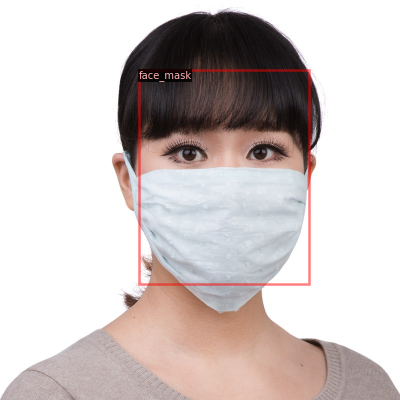

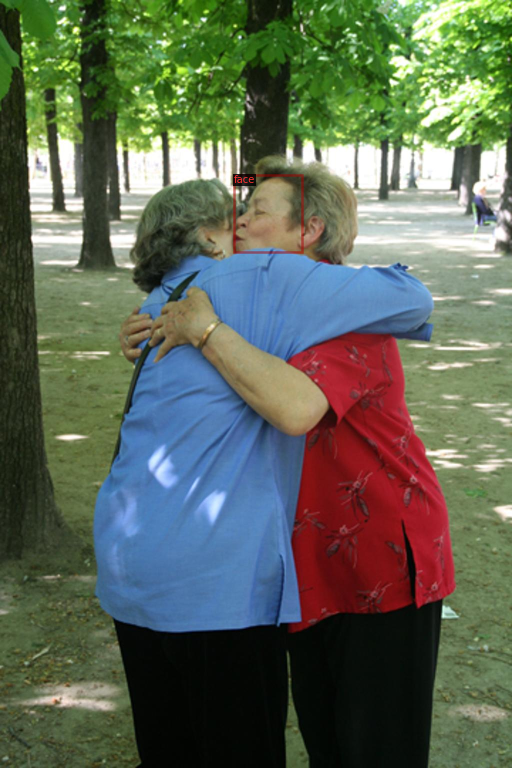

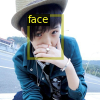

In [14]:
for d in random.sample(train_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=face_mask_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Here we will be doing some fine tuning on the parameters for training. It takes up to 10000 iterations to fine tuned an empty faster RCNN model. The model we will be using here is faster_rcnn_R_50_FPN_3x model which is the most commonly used model in the field of faster RCNN. 


In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
# cfg.clear()
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("face_mask_train",)
# cfg.DATASETS.TEST = ("face_mask_val",)
cfg.DATASETS.TEST = ()

Run with empty weights!

In [16]:
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.000025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # two classes, which is face and face_mask

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[06/13 09:05:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:11, 9.26MB/s]                           


[06/13 09:06:56 d2.checkpoint.c2_model_loading]: Remapping C2 weights ......
[06/13 09:06:56 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.bias            loaded from res2_0_branch2a_bn_beta           of shape (64,)
[06/13 09:06:56 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.running_mean    loaded from res2_0_branch2a_bn_running_mean   of shape (64,)
[06/13 09:06:56 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.running_var     loaded from res2_0_branch2a_bn_running_var    of shape (64,)
[06/13 09:06:56 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.weight          loaded from res2_0_branch2a_bn_gamma          of shape (64,)
[06/13 09:06:56 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.weight               loaded from res2_0_branch2a_w                 of shape (64, 64, 1, 1)
[06/13 09:06:56 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv2.norm.bias         

## Training Curves
Let's have a ook at the training curves in tensorboard:

In [17]:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

# Inference & evaluation using the trained model

## Some trial
Now, let's run inference with the trained model on the face mask's validation dataset. First, let's create a predictor using the model we just trained:

In [0]:
from detectron2.config import get_cfg
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

We have pretrained one final model's weight with 10000 iterations, let's download it for use.

In [19]:
# Create target directory & all intermediate directories if don't exists
dirName = "model"
os.makedirs(dirName, exist_ok=True) 

# download the model's weight into the folder
!wget "https://cloud.tsinghua.edu.cn/f/a02c6a47fb8448588519/?dl=1" -O model/fastRCNN_weights_final.pth

--2020-06-13 09:57:56--  https://cloud.tsinghua.edu.cn/f/a02c6a47fb8448588519/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.8.7
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.8.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/5e4825d5-7855-4166-96af-45026b4cb801/fastRCNN_final.pth [following]
--2020-06-13 09:57:58--  https://cloud.tsinghua.edu.cn/seafhttp/files/5e4825d5-7855-4166-96af-45026b4cb801/fastRCNN_final.pth
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 330018714 (315M) [application/octet-stream]
Saving to: ‘model/fastRCNN_weights_final.pth’

model/fastRCNN_weig 100%[===================>] 314.73M  10.0MB/s    in 35s     

2020-06-13 09:58:33 (8.97 MB/s) - ‘model/fastRCNN_weights_final.pth’ saved [330018714/330018714]



Some initializations:

In [0]:
cfg.DATASETS.TEST = ("face_mask_val",)
cfg.clear()
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# cfg.MODEL.WEIGHTS = 'drive/My Drive/Colab Notebooks/fastRCNN_final.pth'
cfg.MODEL.WEIGHTS = os.path.join(dirName, "fastRCNN_weights_final.pth")
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # two classes, which is face and face_mask
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

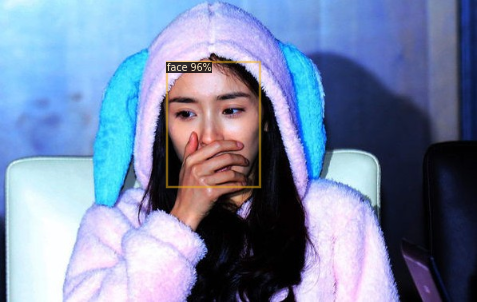

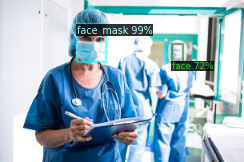

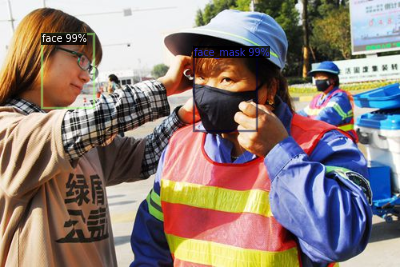

In [21]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=face_mask_metadata, 
                   scale=0.8, 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

## Thorough inference

The above results seems nice, aren't they? Lets do a complete inference on the whole face_mask_val, and save the result for later assessment

In [0]:
from torch import IntTensor
from torch import tensor
import time
import tensorflow as tf
os.makedirs("detection", exist_ok=True) 

In [25]:
count = 0
elapsed = []
for d in test_dicts:    
  count = count + 1
  im = cv2.imread(d["file_name"])
  t = time.time()
  outputs = predictor(im)
  elapsed.append(time.time() - t)
  v = outputs["instances"]
  write_path = 'detection/' + os.path.basename(d["file_name"]).split(".")[0]  + '.txt'
  with open(write_path, 'w') as the_file:
    for i in range(len(v.pred_classes)):
      # what is it?
      if IntTensor.item(v.pred_classes[i]) == 0:
        string = "Face"
      else:
        string = "Mask"
      # score?
      string = string + " " + str(IntTensor.item(v.scores[i]))
      string = string + " " + ' '.join(map(str, v.pred_boxes[i].tensor.cpu().numpy().squeeze()))
      # print(string)
      the_file.write(string +'\n')

print("Verified " + str(count) + " pictures.")

Verified 1839 pictures.


In [26]:
print('The average time for detecting a photo is '+ str(np.mean(elapsed)) + ' seconds')

The average time for detecting a photo is 0.08238316502760389 seconds


zip the inferred file for later assessment

In [0]:
import zipfile
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zipf = zipfile.ZipFile('detection_faster_RCNN_threshold70.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('detection', zipf)
zipf.close()

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~55%. Not bad!

In [28]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("face_mask_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "face_mask_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [06/13 10:04:31 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'face_mask_val'. Trying to convert it to COCO format ...
[06/13 10:04:31 d2.data.datasets.coco]: Converting annotations of dataset 'face_mask_val' to COCO format ...)
[06/13 10:04:48 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/13 10:04:49 d2.data.datasets.coco]: Conversion finished, #images: 1839, #annotations: 3062
[06/13 10:04:49 d2.data.datasets.coco]: Caching COCO format annotations at './output/face_mask_val_coco_format.json' ...
[06/13 10:05:05 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    face    | 2020         | face_mask  | 1042         |
|            |              |            |              |
|   total    | 3062         |            |              |
[06/13 10:05:05 d2.data.common]: Serializing 1839 elements t

OrderedDict([('bbox',
              {'AP': 32.07703910479428,
               'AP-face': 32.71091968663316,
               'AP-face_mask': 31.44315852295539,
               'AP50': 75.22223375657279,
               'AP75': 17.551696211143906,
               'APl': nan,
               'APm': nan,
               'APs': 46.66426830770732})])